# Compare cell lines 

Hani: _"You must redo iPAGE with `--independence=0` option for comparing results between multiple smaples."_

In [1]:
import sys
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from time import time 
from glob import glob
from matplotlib.pyplot import subplots
from itertools import chain
from functools import reduce
from venn import venn

sys.path.append('/rumi/shams/abe/Projects/ipage-down/')

import ipage_down as ipd

## Pairwise correlations:

In [2]:
path_to_cells_rnaseq = glob('*-exp/*_delta_exp_table.txt')
cell_names = [p.split('/')[1].replace('_delta_exp_table','').replace('.txt','').replace('_','') for p in path_to_cells_rnaseq]
all_cells_rnaseq = [
    [name, pd.read_csv(path, sep='\t', header = 0, index_col=0)] for path, name in 
    zip(path_to_cells_rnaseq, cell_names)
]
# all DESeq result tables 
data = dict(all_cells_rnaseq)

# make dataframe of log2FC values for each experiment 
hl60_df = data['hl60'].filter(like='log2FC', axis=1)
hl60_df.columns = hl60_df.columns.str.replace("log2FC", "hl60")

df = pd.concat([data[k].log2FoldChange for k in data.keys() if k !='hl60'],
          axis=1).loc[data['hl60'].index.tolist()]
df.columns=[k for k in data.keys() if k !='hl60']
df = pd.concat([df,hl60_df],axis=1)

https://stackoverflow.com/questions/29432629/plot-correlation-matrix-using-pandas

In [3]:
# df.corr().style.background_gradient(cmap='coolwarm',axis=None)

In [19]:
# import seaborn as sns

def plot_corr(df,vmin=0,vmax=1,save=None):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    alpha = df.columns.values
    cax = ax.matshow(df.corr(),vmin=vmin,vmax=vmax, interpolation='nearest')
    fig.colorbar(cax)

    xaxis = np.arange(len(alpha))
    ax.set_xticks(xaxis)
    ax.set_yticks(xaxis)

    ax.set_xticklabels(alpha, rotation=45)
    ax.set_yticklabels(alpha, rotation=45)

    if save: 
        fig.savefig(save+'.pdf', dpi=350)
        fig.savefig(save+'.png', dpi=350)
    plt.show()
#     corr = df.corr()
#     sns.heatmap(corr, 
#                 xticklabels=corr.columns.values,
#                 yticklabels=corr.columns.values)

renamed 'cell-line-consistency-UpSet.pdf' -> 'figures/cell-line-consistency-UpSet.pdf'
renamed 'cell-line-consistency-Venn.pdf' -> 'figures/cell-line-consistency-Venn.pdf'


In [ ]:
plot_corr(df,save='figures/cell-line-consistency-corr')

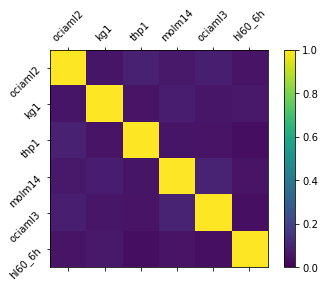

In [14]:
plot_corr(
    pd.concat([
    df.iloc[:,range(5)], 
    df.iloc[:,5] ], 
    axis=1),
#     vmin=0,
#     vmax=0.3
)

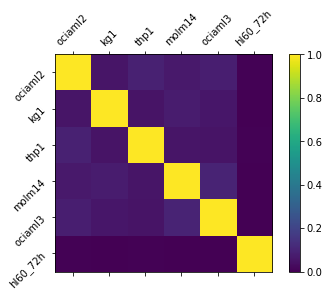

In [15]:
plot_corr(
    pd.concat([
    df.iloc[:,range(5)], 
    df.iloc[:,6] ], 
    axis=1)
)

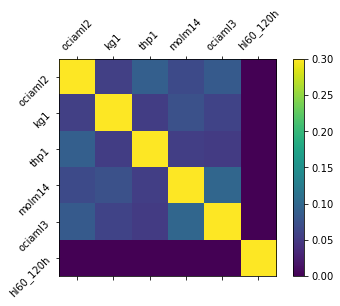

In [18]:
plot_corr(
    pd.concat([
    df.iloc[:,range(5)], 
    df.iloc[:,7] ], 
    axis=1),
    vmax=0.3
)

## Pathway enrichment consistency across cell lines 
iPAGE results. 

In [10]:
celllines = [[path.split('/')[1].replace('_independent0',''),ipd.make_ipage_run_data_frame(path)] for path in glob('*/*delta*independent0/')]
celllines = dict(celllines)

In [11]:
del celllines['6h_delta_stbl']
del celllines['6h_delta_exp']
del celllines['72h_delta_exp']

celllines['hl60_delta_stbl'] = celllines.pop('120h_delta_stbl')
celllines['hl60_delta_exp'] = celllines.pop('120h_delta_exp')

In [12]:
# ipd.style_clean_pvmatrix(hl60[0][1])

In [97]:
Exp_dn  = dict([[std,{x[0] for x in celllines[std].index[celllines[std].iloc[:,0] > 2].tolist()}] for std in celllines if 'delta_exp' in std])
Exp_up  = dict([[std,{x[0] for x in celllines[std].index[celllines[std].iloc[:,1] > 2].tolist()}] for std in celllines if 'delta_exp' in std])
Stbl_dn = dict([[std,{x[0] for x in celllines[std].index[celllines[std].iloc[:,0] > 2].tolist()}] for std in celllines if 'delta_stbl' in std])
Stbl_up = dict([[std,{x[0] for x in celllines[std].index[celllines[std].iloc[:,1] > 2].tolist()}] for std in celllines if 'delta_stbl' in std])

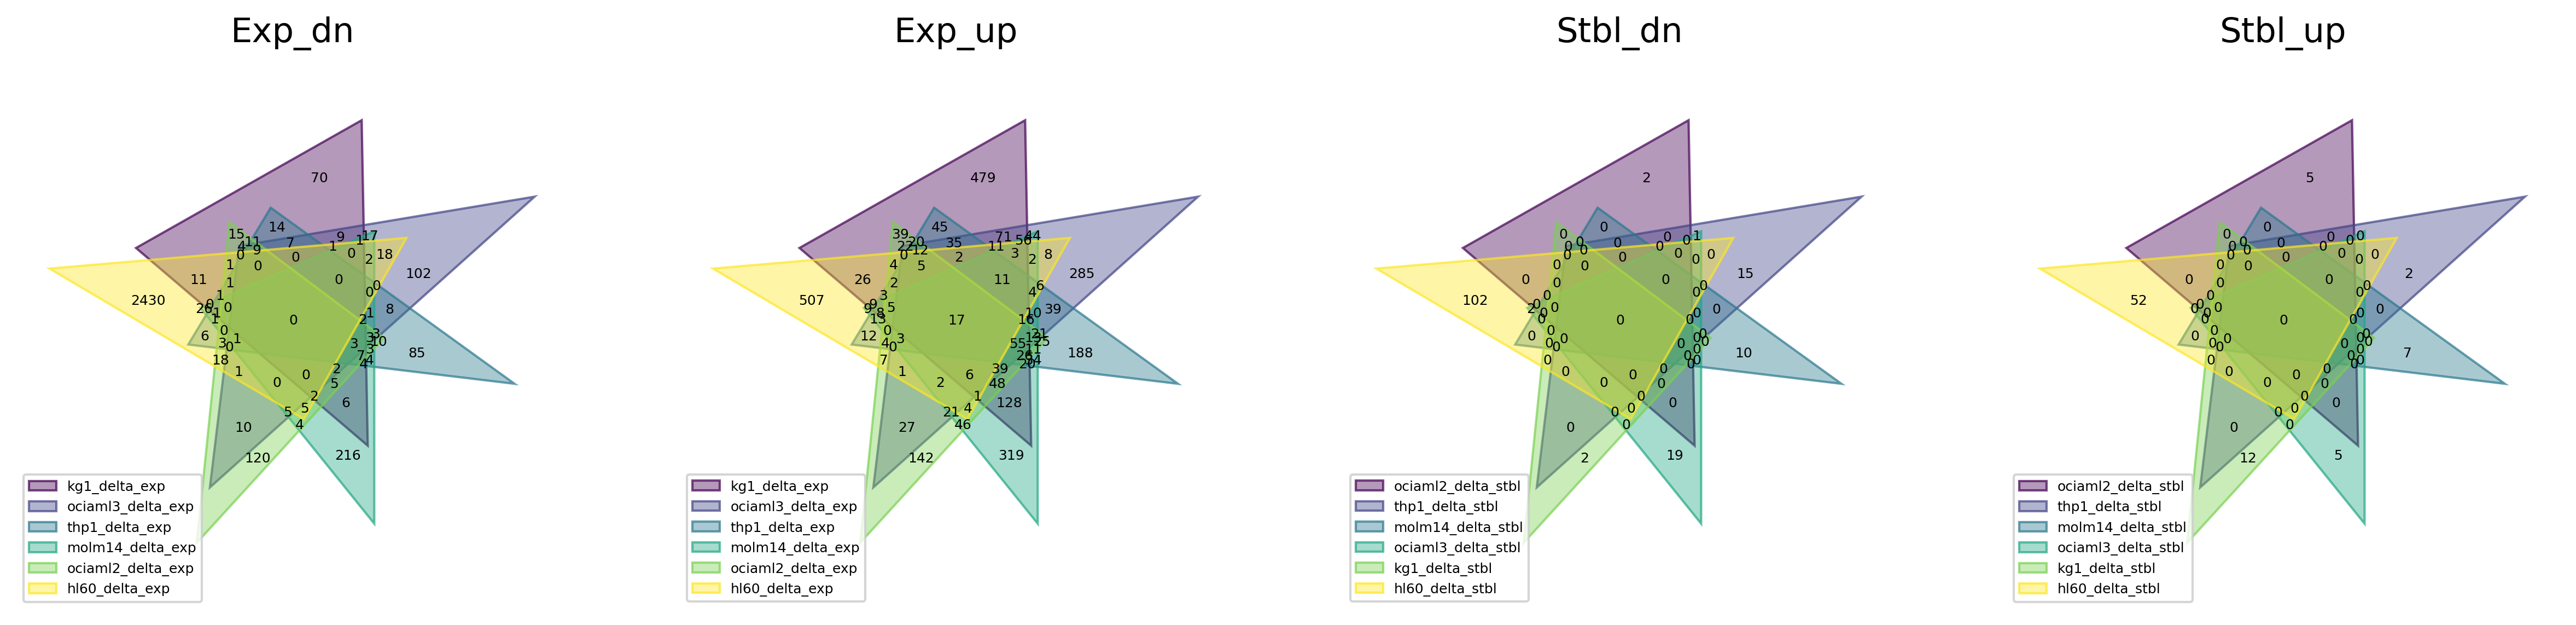

In [14]:
fig, ((ax1,ax2,ax3,ax4)) = subplots(ncols=4, nrows=1, figsize=(20, 10),dpi=300)

for std,ax in zip(['Exp_dn', 'Exp_up', 'Stbl_dn', 'Stbl_up'],[ax1,ax2,ax3,ax4]):
    venn(eval(std),fontsize=6,
#          legend_loc=None,  
         legend_loc="lower left",  
         ax=ax)
    ax.set_title(std,fontsize=15)

fig.savefig('cell-line-consistency-Venn.pdf')
plt.show()

## UpSetPlot

https://upsetplot.readthedocs.io/en/stable/


In [24]:
import upsetplot as us

In [114]:
from matplotlib.backends.backend_pdf import PdfPages


In [ ]:
with PdfPages('cell-line-consistency-UpSet.pdf') as pdf:
    fig1 = plt.figure()
    upset1 = us.UpSet(us.from_contents(Exp_dn),orientation='horizontal',show_counts=True)
    upset1.plot(fig=fig1)
    plt.title('Exp_dn',fontsize=20)
    pdf.savefig()
    
    fig2 = plt.figure()
    upset2 = us.UpSet(us.from_contents(Exp_up),orientation='horizontal',show_counts=True)
    upset2.plot(fig=fig2)
    plt.title('Exp_up',fontsize=20)
    pdf.savefig()
    
    fig3 = plt.figure()
    upset3 = us.UpSet(us.from_contents(Stbl_dn),orientation='horizontal',show_counts=True)
    upset3.plot(fig=fig3)
    plt.title('Stbl_dn',fontsize=20)
    pdf.savefig()
    
    fig4 = plt.figure()
    upset = us.UpSet(us.from_contents(Stbl_up),orientation='horizontal',show_counts=True)
    upset.plot()
    plt.title('Stbl_up',fontsize=15)
    pdf.savefig()

In [111]:
# reduce(set.intersection, Exp_up.values())

In [112]:
# ann = ipd.make_annotation_dict(celllines['ociaml2_delta_exp'].loc[reduce(set.intersection, Exp_up.values()),])

___
- https://github.com/tanghaibao/goatools
- https://gseapy.readthedocs.io/en/latest/index.html

In [ ]:
from goatools.base import download_go_basic_obo